In [8]:
import os
import argparse
from time import time
from pathlib import Path
import pandas as pd     
import numpy as np
import plotly.figure_factory as plotly_ff
import plotly.express as plotly_x
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


## Read a file and display a few rows

In [13]:
df = pd.read_csv('./analysis_data.csv', iterator=False)
print(df.head())

# Display basic information about the dataset
df.info()

# Get summary statistics of numeric columns
df.describe()

     station_name                      created_dt  entries    exits
0  VERNON-JACKSON  2023-07-28 16:00:00.000000 UTC  6022170  4947323
1  VERNON-JACKSON  2023-07-28 12:00:00.000000 UTC  6022068  4947077
2  VERNON-JACKSON  2023-07-28 04:00:00.000000 UTC  6021918  4946510
3  VERNON-JACKSON  2023-07-28 08:00:00.000000 UTC  6021954  4946739
4  VERNON-JACKSON  2023-07-28 00:00:00.000000 UTC  6021918  4946498
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   station_name  100000 non-null  object
 1   created_dt    100000 non-null  object
 2   entries       100000 non-null  int64 
 3   exits         100000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


,entries,exits
count,1.000000e+05,1.000000e+05
mean,3.691270e+07,2.954513e+07
std,2.085400e+08,1.828396e+08
min,0.000000e+00,0.000000e+00
25%,2.712620e+05,1.953752e+05
50%,1.358986e+06,1.004706e+06
75%,6.155866e+06,4.450152e+06
max,2.147171e+09,2.121476e+09


# Data Cleaning and Preprocessing



In [19]:
# Check for null values in each column
null_counts = df.isnull().sum()
null_counts.head()

# fill null values with a specific value
df = df.fillna(0)

# cast a column to a specific data type
df['date'] = pd.to_datetime(df['created_dt'])

numeric_cols = ['entries','exits']
df[numeric_cols] = df[numeric_cols].astype(int)

# Rename all columns to lowercase
df.columns = [col.lower() for col in df.columns]

In [25]:
# measure outliers for entries and exits
# Calculate z-scores within each station group
z_scores = df.groupby('station_name')[numeric_cols] \
        .transform(lambda x: (x - x.mean()) / x.std())

# Set a threshold for outliers
threshold = 3

# Identify outliers based on z-scores within each station
outliers = (z_scores.abs() > threshold)

# Print the count of outliers for each station
outliers_by_station = outliers.groupby(df['station_name']).sum()
print(outliers_by_station)

                 entries  exits
station_name                   
1 AV                  25     25
103 ST                 0      6
104 ST                 0      0
111 ST                24      0
116 ST                 0      0
...                  ...    ...
WHITLOCK AV            0      0
WILSON AV              0      0
WOODHAVEN BLVD         0     36
WORLD TRADE CTR       24     24
YORK ST                0      0

[320 rows x 2 columns]


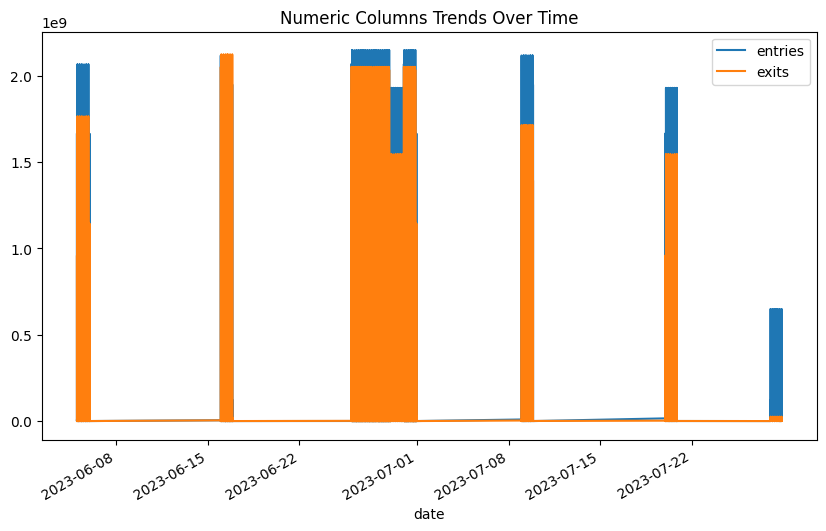

In [26]:
# analyze time series data
df.set_index('date', inplace=True)

# Plot trends for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].plot(figsize=(10, 6))
plt.title('Numeric Columns Trends Over Time')
plt.show()

## Inspect a distribution of arrivals and departures at certain time slots

In [27]:

# Define time (hr) slots
time_slots = {
    'morning': (8, 11),
    'afternoon': (12, 15),
    'night': (16, 20)
}
# cast the date column to datetime
df["created_dt"] = pd.to_datetime(df['created_dt'])
df["exits"] = df["exits"].astype(int)
df["entries"] = df["entries"].astype(int)

# Calculate average arrivals (exits) and departures (entries) for each time slot
for slot, (start_hour, end_hour) in time_slots.items():
    slot_data = df[(df['created_dt'].dt.hour >= start_hour) & (df['created_dt'].dt.hour <= end_hour)]
    avg_arrivals = slot_data['exits'].mean()
    avg_departures = slot_data['entries'].mean()
    print(f"{slot.capitalize()} - Avg Arrivals: {avg_arrivals:.2f}, Avg Departures: {avg_departures:.2f}")

Morning - Avg Arrivals: 29600920.10, Avg Departures: 37095699.20
Afternoon - Avg Arrivals: 29563456.84, Avg Departures: 36899642.45
Night - Avg Arrivals: 32372916.28, Avg Departures: 40061605.18


## Find outliers for arrivals (morning) and departures (night)
- entries are the departing commuters
- exits are the arriving commuters
- station_name provides the location

In [28]:

# get the departures and arrivals for each station at the morning and night time slots
df_morning_arrivals =  df[(df['created_dt'].dt.hour >= time_slots['morning'][0]) & (df['created_dt'].dt.hour < time_slots['morning'][1])]
df_night_departures = df[(df['created_dt'].dt.hour >= time_slots['night'][0] ) & (df['created_dt'].dt.hour < time_slots['night'][1])]
# Calculate the mean arrivals and departures for each station
mean_arrivals_by_station = df_morning_arrivals.groupby('station_name')['exits'].mean()
mean_departures_by_station = df_night_departures.groupby('station_name')['entries'].mean()

# Calculate the z-scores for the differences between mean arrivals and departures
z_scores = (mean_arrivals_by_station - mean_departures_by_station) / np.sqrt(mean_arrivals_by_station.var() + mean_departures_by_station.var())

# Set a z-score threshold to identify outliers
z_score_threshold = 2 # You can adjust this value based on your needs

# Identify stations with outliers
outlier_stations = z_scores[abs(z_scores) > z_score_threshold]

print("Stations with outliers:")
print(outlier_stations)


Stations with outliers:
station_name
183 ST          -3.170777
BAYCHESTER AV   -4.340479
JACKSON AV      -4.215668
NEW LOTS         3.124990
dtype: float64


# Statistical Analysis

In [36]:
# Summary statistics
measures = ['entries','exits']
dims = ['station_name']

print("Summary Statistics:")
print(df[measures].describe() / 10000)

# Filter rows for the month of July for morning and night time slots
df_morning_july = df_morning_arrivals[df_morning_arrivals['created_dt'].dt.month == 7][measures + dims]
df_night_july = df_night_departures[df_night_departures['created_dt'].dt.month == 7][measures + dims]

correlation_data = []
for station in df_morning_july['station_name'].unique():
    morning_arrival = df_morning_july[df_morning_july['station_name'] == station]['exits'].values[0]
    evening_departure = df_night_july[df_night_july['station_name'] == station]['entries'].values[0]
    correlation_data.append({'station_name': station, 'arrivals': morning_arrival, 'departures': evening_departure})

df_correlation = pd.DataFrame(correlation_data)

# Select top 10 stations with most morning arrivals
top_stations = df_correlation.groupby('station_name')['arrivals'].sum().nlargest(10).index
df_top_stations = df_correlation[df_correlation['station_name'].isin(top_stations)]

# Create a scatter matrix to visualize relationships between numeric columns
fig_scatter = plotly_x.scatter(df_top_stations, x='arrivals', y='departures', color='station_name',
                         title='Morning Arrivals vs Evening Departures', opacity=0.75, width=980, height=650 )
fig_scatter.show()

# Create a correlation matrix
corr_matrix = df_top_stations.corr()

# Plot correlation matrix using Plotly
fig_corr = plotly_x.imshow(corr_matrix,
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                title="Correlation Matrix for Top 10 Stations: Morning Arrivals vs Night Departures")

corr_matrix_all = df_correlation.corr()

# Plot correlation matrix using Plotly
fig_corr_all = plotly_x.imshow(corr_matrix_all,
                x=corr_matrix_all.columns,
                y=corr_matrix_all.columns,
                title="Correlation Matrix for all Stations: Morning Arrivals vs Night Departures")
fig_corr_all.show()


Summary Statistics:
             entries          exits
count      10.000000      10.000000
mean     3691.269728    2954.513148
std     20853.999335   18283.964419
min         0.000000       0.000000
25%        27.126200      19.537525
50%       135.898650     100.470600
75%       615.586650     445.015200
max    214717.057100  212147.622600


/tmp/ipykernel_9779/191152296.py:30: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/tmp/ipykernel_9779/191152296.py:38: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



## Hypothesis Testing

In [34]:
# Perform Pearson correlation test
def test_arrival_departure_correlation(df: pd.DataFrame, label: str) -> None:
   corr_coefficient, p_value = pearsonr(df['arrivals'], df['departures'])   
   p_value = round(p_value, 5)
   
   if p_value < 0.05:
      conclusion = f"The correlation {label} is statistically significant."
   else:
      conclusion = f"The correlation {label} is not statistically significant."
      
   print(f"Pearson Correlation {label} - Coefficient : {corr_coefficient} P-Value : {p_value}")    
   print(f"Conclusion: {conclusion}")

test_arrival_departure_correlation(df_top_stations, 'top-10 stations')

test_arrival_departure_correlation(df_correlation, 'all stations')

Pearson Correlation top-10 stations - Coefficient : -0.1411184274451126 P-Value : 0.69738
Conclusion: The correlation top-10 stations is not statistically significant.
Pearson Correlation all stations - Coefficient : 0.738028840267009 P-Value : 0.0
Conclusion: The correlation all stations is statistically significant.


## Business Intelligence Show the total entries by station, use a subset of data

In [59]:
# Calculate total passengers for arrivals and departures
total_arrivals = df['exits'].sum() 
total_departures = df['entries'].sum() 

print(f"Total Arrivals: {total_arrivals} Total Departures: {total_departures}")

# Create distribution analysis by station
df_by_station = df.groupby(["station_name"], as_index=False)[measures].sum()
print(df_by_station.head(5))

# Create distribution analysis by day of the week
df_by_date = df.groupby(["created_dt"], as_index=False)[measures].sum()
day_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
df_by_date["weekday"] = pd.Categorical(df_by_date["created_dt"].dt.strftime('%a'), categories=day_order, ordered=True)
df_entries_by_date =  df_by_date.groupby(["weekday"], as_index=False)[measures].sum()
print(df_entries_by_date.head(5))

# Create distribution analysis time slots
for slot, (start_hour, end_hour) in time_slots.items():
    slot_data = df[(df['created_dt'].dt.hour >= start_hour) & (df['created_dt'].dt.hour <= end_hour)]
    arrivals = slot_data['exits'].sum()
    departures = slot_data['entries'].sum()
    print(f"{slot.capitalize()} - Arrivals: {arrivals:.2f}, Departures: {departures:.2f}")



Total Arrivals: 2954513147693 Total Departures: 3691269727684
  station_name      entries        exits
0         1 AV  41921835330   4723874242
1       103 ST   1701063755   1505114656
2       104 ST  60735889120  35317207533
3       111 ST   1856383672    840818137
4       116 ST   7419106031   8292936323
  weekday       entries         exits
0     Sun   83869272617   53997290047
1     Mon  839105447014  667971771875
2     Tue  723988041023  592238758942
3     Wed  728728461351  594670413050
4     Thu   80966812864   51232966458
Morning - Arrivals: 494601773970.00, Departures: 619832037915.00
Afternoon - Arrivals: 493029769709.00, Departures: 615375337214.00
Night - Arrivals: 814729184132.00, Departures: 1008230417627.00
